##### Bibliotecas utilizadas

In [9]:
import requests 
import pandas as pd
import numpy as np
import datetime
import random

##### Gerando dados

In [214]:
# Utilizado caso ainda não exista uma base de dados

df_final = pd.DataFrame()
contador = 1 
for i in range (52):
    dados = requests.get('http://localhost:3000/api/ep1').json()
    df = pd.DataFrame(dados)
    df['semana']  = contador
    df_final = pd.concat([df, df_final], axis = 0)
    contador +=1



##### Tratando dados

In [215]:
# Ajustando data 
df_final['date'] = df_final['date'].apply(lambda x:datetime.datetime.fromtimestamp(x))

In [216]:
# Ordenando dados 
df_final.sort_values('semana', axis = 0, ascending = True, inplace = True)

In [217]:
# Ajustando valores negativos e NaN e convertendo os números em inteiro
colunas = df_final.columns

for coluna in colunas[2:len(colunas)-1]:
        df_final[coluna] = df_final[coluna].fillna(0) 
        df_final[coluna] = df_final[coluna].apply(lambda x: int(abs(x)))
        

In [218]:
# Ajustando nomes das colunas para a comparação entre elas funcionar. 
df_final.rename(columns={'prod_0':'prod_00', 'prod_1':'prod_01', 'prod_2':'prod_02', \
    'prod_3':'prod_03', 'prod_4':'prod_04', 'prod_5':'prod_05',\
        'prod_6':'prod_06', 'prod_7':'prod_07', 'prod_8':'prod_08', \
        'prod_9':'prod_09'}, inplace = True)

In [219]:
# gerando csv
df_final.to_csv('ada_project/all_sells.csv', encoding = 'iso-8859-1', index= False)

##### Gerando preços

In [3]:
df_final = pd.read_csv('ada_project/all_sells.csv', encoding = 'iso-8859-1')

In [4]:
# Gerando preços aleatórios para produtos novos e segunda semana. 

df_precos = df_final.copy() 

# Apagando todas as linhas do dataframe copiado.
df_precos.drop(list(range(len(df_final))), axis = 0, inplace = True, errors= 'ignore')

# Apagando colunas que não serão necessárias. 
df_precos.drop(['id', 'total_por_unidade','date', 'total_por_kg', \
    'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'], axis = 1, errors= 'ignore', inplace = True)

df_precos.loc[0] = [random.randint(10,30) for x in range(df_precos.shape[1])]
df_precos.loc[1] = df_precos.loc[0]
df_precos['semana'].loc[0] = 1
df_precos['semana'].loc[1] = 2



In [ ]:
# Gerando a variação relativa.

df_consulta = pd.read_csv('ada_project/all_sells.csv', encoding = 'iso-8859-1')
df_consulta = df_consulta.groupby('semana').mean().diff()

# Definindo percentual de variação do preço do produto. 

f_v = 0.5 + 1/(1+np.exp(1)**-df_consulta)
f_v.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace = True, errors = 'ignore')
f_v.drop([1],axis=0,inplace = True)
f_v.reset_index(inplace= True)

# Criando linhas no dataframe com valor 0. 

for x in range(f_v.shape[0]):
    df_precos.loc[df_precos.shape[0]] = 0

# Gerando valores para as demais semanas

x = 1
v = -1
for linha, valor in f_v.iterrows(): 
    x+=1
    v+=1 
    for coluna in df_precos: 
        df_precos[coluna].loc[x] = f_v[coluna][v] * df_precos[coluna][x-1]
        df_precos['semana'].loc[x] = x+1
        
df_precos.drop([df_precos.shape[0]-1], axis = 0, inplace = True)
df_precos = round(df_precos, 2)
df_precos['semana'] = df_precos['semana'].astype(int)

In [222]:
# Gerando csv

df_precos.to_csv('ada_project/weekly_price.csv', encoding = 'iso-8859-1', index= False)

<AxesSubplot: xlabel='semana'>

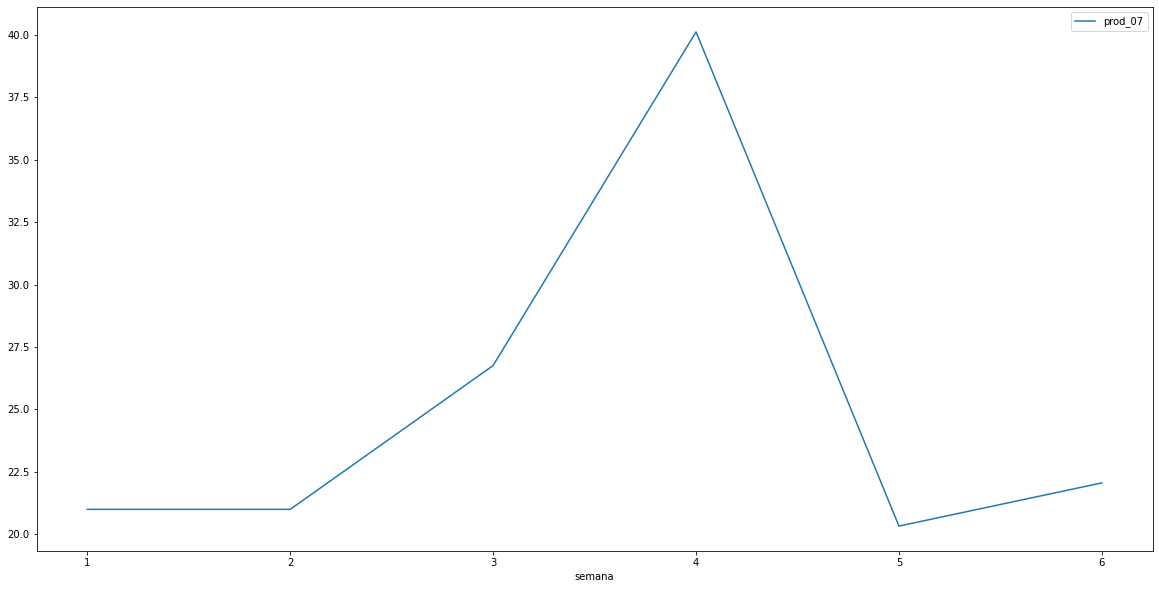

In [64]:
df_precos.loc[:5].plot(x = 'semana', y = 'prod_07', kind= 'line', figsize = (20,10))

##### Gerando transações do mês

In [22]:
df_vendas = df_final.copy()

In [23]:
# Reduzindo data
df_vendas['date'] = (df_vendas['date'].map(lambda x: str(x)[:10]))


In [24]:
# Eliminando colunas
df_vendas.drop(['Unnamed: 0', 'id','semana'], axis = 1, inplace = True, errors='ignore')


In [ ]:
df_vendas = df_vendas.groupby('date').sum().reset_index().sort_values('date',axis = 0)
df_vendas['balance'] = df_vendas.sum(axis = 1)

In [227]:
# Gerando csv 
df_vendas.to_csv('ada_project/monthly_sales.csv', encoding = 'iso-8859-1',index= False)

##### Gerando total de vendas mensal

In [130]:
df_vendas = pd.read_csv('ada_project/all_sells.csv', encoding = 'iso-8859-1')


In [ ]:
df_vendas.drop(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'semana'], axis = 1, inplace= True, errors ='ignore')
df_vendas['date'] = df_vendas['date'].apply(lambda x: str(x)[:7])
df_vendas = df_vendas.groupby(['date']).sum().reset_index().sort_values('date', axis = 0)
df_vendas['balance'] = df_vendas.sum(axis = 1)


In [133]:
df_vendas.to_csv('ada_project/month_revenue.csv', encoding ='iso-8859-1', index= False)